# 前期准备

# 3.18先行测试版

导入所需库

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib
import chinese_calendar as cc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import pickle

设置中文字体

In [29]:
matplotlib.rcParams["font.sans-serif"] = ["Liberation Sans"]

# 数据预处理

读取并合并市场披露数据（包括对齐24个点和96个点的数据）

In [30]:
data_path = "../data/"
data_path_2024 = data_path + "2024/"
data_path_2025 = data_path + "2025/"

elec_price_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df_2024 = pd.read_csv(data_path_2024 + "内蒙2024新能源出力数据_96点_cleaned.csv", sep="\t")

df_15_features = [elec_out_price_df_2024, non_martket_elec_gen_df_2024, ele_load_df_2024, new_energy_elec_gen_df_2024]

for i in range(len(df_15_features)):
    df = df_15_features[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').mean()
    df_15_features[i] = df

elec_price_df_2024['datetime'] = pd.to_datetime(elec_price_df_2024['datetime'])
elec_price_df_2024.set_index('datetime', inplace=True)

merged_df = pd.concat([elec_price_df_2024] + df_15_features, axis=1)
print(merged_df.loc['2024-01-02'])

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格     东送计划预测  \
datetime                                                                    
2024-01-02 00:00:00    328.09     264.64     381.57     372.27  2100.0000   
2024-01-02 01:00:00    364.71     347.72     378.77     274.10  2100.0000   
2024-01-02 02:00:00    386.24     384.98     387.28     221.28  2099.9975   
2024-01-02 03:00:00    388.32     389.00     387.76     216.79  2100.0000   
2024-01-02 04:00:00    280.56     210.77     338.91     208.40  2100.0000   
2024-01-02 05:00:00    326.74     275.32     369.84       0.25  2100.0000   
2024-01-02 06:00:00    370.06     346.92     389.27       0.85  2100.0000   
2024-01-02 07:00:00    408.80     416.22     402.58      17.32  2100.0000   
2024-01-02 08:00:00    413.95     412.62     415.12     259.53  2755.5000   
2024-01-02 09:00:00    296.40     220.77     366.52     299.84  3805.5000   
2024-01-02 10:00:00    171.27     139.11     201.10     158.74  4200.0000   

预处理天气数据

In [31]:
weather_data_2024_all = pd.read_csv(data_path_2024 + '内蒙2024天气.csv', sep=',')

''' 天气参数
id: 数据id
region_code: 行政区号
region_name: 行政区名
t2m: 2米温度
ws10m: 10米风速
ssrd: 向下表面太阳辐射（辐照）
tp: 总降水量(precipitation)
rh: 相对湿度
datetime: 时间戳
lng: 经度
lat: 纬度
'''
# 设置列名
weather_data_2024_all.columns = ['id', 'region_code', 'region_name', 't2m', 'ws10m', 'ssrd', 'tp', 'rh', 'datetime', 'lng', 'lat']
weather_data_2024 = weather_data_2024_all.drop(columns=['id', 'lng', 'lat', 'region_name'])
weather_data_2024['datetime'] = pd.to_datetime(weather_data_2024['datetime'], dayfirst=True)
weather_data_2024.set_index('datetime', inplace=True)
weather_data_2024_filtered = weather_data_2024[weather_data_2024['region_code'].isin([1501, 1502])]

weather_1501 = weather_data_2024_filtered[weather_data_2024_filtered['region_code'] == 1501].copy()
weather_1502 = weather_data_2024_filtered[weather_data_2024_filtered['region_code'] == 1502].copy()
weather_1501.drop(columns=['region_code'], inplace=True)
weather_1502.drop(columns=['region_code'], inplace=True)
weather_1501.rename(columns={
    't2m': 't2m_1501',
    'ws10m': 'ws10m_1501',
    'ssrd': 'ssrd_1501',
    'tp': 'tp_1501',
    'rh': 'rh_1501'
}, inplace=True)
weather_1502.rename(columns={
    't2m': 't2m_1502',
    'ws10m': 'ws10m_1502',
    'ssrd': 'ssrd_1502',
    'tp': 'tp_1502',
    'rh': 'rh_1502'
}, inplace=True)

weather_1501 = weather_1501[~weather_1501.index.duplicated(keep='first')]
weather_1502 = weather_1502[~weather_1502.index.duplicated(keep='first')]

merged_weather_2024 = pd.merge(weather_1501, weather_1502, left_index=True, right_index=True, how='outer')

print(merged_weather_2024.loc['2024-01-02'][0:3])

                     t2m_1501  ws10m_1501  ssrd_1501  tp_1501  rh_1501  \
datetime                                                                 
2024-01-02 00:00:00   -9.3586      0.8648        0.0      0.0   0.7457   
2024-01-02 01:00:00  -10.2181      0.7868        0.0      0.0   0.7487   
2024-01-02 02:00:00  -10.1093      0.8430        0.0      0.0   0.7481   

                     t2m_1502  ws10m_1502  ssrd_1502  tp_1502  rh_1502  
datetime                                                                
2024-01-02 00:00:00  -12.7961      2.0977        0.0      0.0   0.7343  
2024-01-02 01:00:00  -14.1596      2.5779        0.0      0.0   0.7424  
2024-01-02 02:00:00  -14.6581      2.8571        0.0      0.0   0.7470  


合并数据+丢弃预测数据

In [32]:
merged_df_with_weather = merged_df.merge(merged_weather_2024, left_index=True, right_index=True, how='outer')
merged_df_with_weather['price_bidding_space'] = merged_df_with_weather['统调负荷预测'] + merged_df_with_weather['东送计划预测'] - merged_df_with_weather['新能源出力预测'] - merged_df_with_weather['非市场出力计划']
merged_df_filtered = merged_df_with_weather.drop(columns=['东送计划实测', '非市场出力计划实测', '统调负荷实测', '新能源出力实测', '风电出力实测', '光伏出力实测'])

print(merged_df_filtered.loc['2024-01-02'][0:3])

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格     东送计划预测  \
datetime                                                                    
2024-01-02 00:00:00    328.09     264.64     381.57     372.27  2100.0000   
2024-01-02 01:00:00    364.71     347.72     378.77     274.10  2100.0000   
2024-01-02 02:00:00    386.24     384.98     387.28     221.28  2099.9975   

                       非市场出力计划    统调负荷预测    新能源出力预测     风电出力预测  光伏出力预测  ...  \
datetime                                                                ...   
2024-01-02 00:00:00  6625.5225  41067.35  14503.555  14457.025  46.530  ...   
2024-01-02 01:00:00  6589.3075  39946.65  15205.300  15141.550  63.750  ...   
2024-01-02 02:00:00  6614.6975  39880.25  15584.530  15513.425  71.105  ...   

                     ws10m_1501  ssrd_1501  tp_1501  rh_1501  t2m_1502  \
datetime                                                                 
2024-01-02 00:00:00      0.8648        0.0      0.0   0.7457  -12.7961

特征相关性

In [33]:
merged_df_filtered.corr()

,全网统一出清电价,呼包东统一出清电价,呼包西统一出清电价,日前预出清电能价格,东送计划预测,非市场出力计划,统调负荷预测,新能源出力预测,风电出力预测,光伏出力预测,...,ws10m_1501,ssrd_1501,tp_1501,rh_1501,t2m_1502,ws10m_1502,ssrd_1502,tp_1502,rh_1502,price_bidding_space
全网统一出清电价,1.000000,0.994651,0.995848,0.814171,0.048511,-0.076018,0.212592,-0.625751,-0.556556,-0.294657,...,-0.326692,-0.226712,-0.052249,0.062322,0.025129,-0.335770,-0.227465,-0.041945,0.030401,0.683112
呼包东统一出清电价,0.994651,1.000000,0.981162,0.810929,0.044058,-0.080935,0.201553,-0.630744,-0.575721,-0.279313,...,-0.328372,-0.212769,-0.049954,0.075304,0.044744,-0.332523,-0.212559,-0.039776,0.041759,0.684876
呼包西统一出清电价,0.995848,0.981162,1.000000,0.809618,0.051759,-0.070658,0.220577,-0.615757,-0.534176,-0.306165,...,-0.322139,-0.237682,-0.053813,0.050642,0.007183,-0.335598,-0.239284,-0.043495,0.020463,0.675429
日前预出清电能价格,0.814171,0.810929,0.809618,1.000000,0.097657,-0.095177,0.309138,-0.660497,-0.566000,-0.336417,...,-0.351386,-0.275256,-0.056693,0.056281,-0.049254,-0.350905,-0.278912,-0.057691,0.018358,0.751069
东送计划预测,0.048511,0.044058,0.051759,0.097657,1.000000,0.225091,0.437503,0.234858,0.035694,0.318732,...,0.173987,0.295928,-0.031309,-0.301290,0.043910,0.147938,0.299871,-0.056340,-0.321335,0.008813
非市场出力计划,-0.076018,-0.080935,-0.070658,-0.095177,0.225091,1.000000,0.237444,0.181184,0.305883,-0.088622,...,0.104941,-0.137542,0.012983,0.026956,-0.106767,0.130835,-0.137988,0.011720,0.014147,-0.166931
统调负荷预测,0.212592,0.201553,0.220577,0.309138,0.437503,0.237444,1.000000,0.077465,0.102534,-0.003944,...,-0.076857,-0.052072,-0.077838,-0.104233,-0.370230,-0.029568,-0.047925,-0.090978,-0.116878,0.230182
新能源出力预测,-0.625751,-0.630744,-0.615757,-0.660497,0.234858,0.181184,0.077465,1.000000,0.760668,0.625619,...,0.584235,0.542636,-0.003441,-0.335947,0.026127,0.583575,0.553082,-0.007245,-0.340734,-0.942099
风电出力预测,-0.556556,-0.575721,-0.534176,-0.566000,0.035694,0.305883,0.102534,0.760668,1.000000,-0.030526,...,0.397394,-0.081790,0.035826,-0.061081,-0.203707,0.458566,-0.077996,0.035992,-0.055821,-0.739637
光伏出力预测,-0.294657,-0.279313,-0.306165,-0.336417,0.318732,-0.088622,-0.003944,0.625619,-0.030526,1.000000,...,0.422279,0.934003,-0.048348,-0.444003,0.285014,0.347730,0.945506,-0.054406,-0.457680,-0.561739


创建电价的滞后特征

In [34]:
# merged_df_filtered['east_price_lag_1'] = merged_df_filtered['呼包东统一出清电价'].shift(1)
# merged_df_filtered['east_price_lag_2'] = merged_df_filtered['呼包东统一出清电价'].shift(2)
# merged_df_filtered['east_price_lag_3'] = merged_df_filtered['呼包东统一出清电价'].shift(3)

# merged_df_filtered['west_price_lag_1'] = merged_df_filtered['呼包西统一出清电价'].shift(1)
# merged_df_filtered['west_price_lag_2'] = merged_df_filtered['呼包西统一出清电价'].shift(2)
# merged_df_filtered['west_price_lag_3'] = merged_df_filtered['呼包西统一出清电价'].shift(3)

# for day in range(1, 8):
#     merged_df_filtered[f'east_price_lag_day_{day}'] = merged_df_filtered['呼包东统一出清电价'].shift(24 * day)
#     merged_df_filtered[f'west_price_lag_day_{day}'] = merged_df_filtered['呼包西统一出清电价'].shift(24 * day)

merged_df_filtered = merged_df_filtered.dropna()

print(merged_df_filtered.head())

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格     东送计划预测  \
datetime                                                                    
2024-01-01 09:00:00    430.32     426.92     433.48     457.50  3805.5000   
2024-01-01 10:00:00    409.45     407.92     410.91     422.50  4200.0000   
2024-01-01 11:00:00    384.81     397.11     373.26     387.50  4200.0000   
2024-01-01 12:00:00    348.15     354.58     342.46     220.25  3544.4975   
2024-01-01 13:00:00      8.24       0.00      15.26       0.14  3150.0000   

                       非市场出力计划     统调负荷预测     新能源出力预测     风电出力预测     光伏出力预测  \
datetime                                                                      
2024-01-01 09:00:00  6530.1175  41794.525  13527.8425  12813.325   714.5175   
2024-01-01 10:00:00  6539.4125  41782.450  15678.7600  12559.650  3119.1100   
2024-01-01 11:00:00  6603.2050  41728.425  17931.3600  12092.225  5839.1350   
2024-01-01 12:00:00  6567.9600  41542.250  19255.7275  11652.375 

添加节假日、季节、工作日与周末、星期几特征

In [35]:
merged_df_filtered['weekday_num'] = merged_df_filtered.index.weekday
merged_df_filtered['is_workday'] = (merged_df_filtered['weekday_num'] < 5).astype(int)
merged_df_filtered['is_holiday'] = merged_df_filtered.index.to_series().apply(lambda x : 1 if cc.is_holiday(x.date()) else 0)

def get_season(month):
    if month in [3, 4, 5]:
        return 0 # Spring
    elif month in [6, 7, 8]:
        return 1 # Summer
    elif month in [9, 10, 11]:
        return 2 # Autumn
    else:
        return 3 # Winter

merged_df_filtered['season'] = merged_df_filtered.index.month.map(get_season)

print(merged_df_filtered.columns)

print(merged_df_filtered.loc['2024-10-01'][0:1])
print(merged_df_filtered.loc['2024-10-02'][0:1])
print(merged_df_filtered.loc['2024-03-01'][0:1])

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划',
       '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测', 't2m_1501', 'ws10m_1501',
       'ssrd_1501', 'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502',
       'ssrd_1502', 'tp_1502', 'rh_1502', 'price_bidding_space', 'weekday_num',
       'is_workday', 'is_holiday', 'season'],
      dtype='object')
            全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格  东送计划预测  非市场出力计划  \
datetime                                                                 
2024-10-01   25.8795    8.52343    41.0747       10.0  1050.0  6286.97   

               统调负荷预测   新能源出力预测    风电出力预测  光伏出力预测  ...  t2m_1502  ws10m_1502  \
datetime                                           ...                         
2024-10-01  38111.625  16380.57  16317.25   63.32  ...    4.4284      3.4991   

            ssrd_1502  tp_1502  rh_1502  price_bidding_space  weekday_num  \
datetime                                                                    
2024-10-01   

In [36]:
print(merged_df_filtered.columns)

Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划',
       '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测', 't2m_1501', 'ws10m_1501',
       'ssrd_1501', 'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502',
       'ssrd_1502', 'tp_1502', 'rh_1502', 'price_bidding_space', 'weekday_num',
       'is_workday', 'is_holiday', 'season'],
      dtype='object')


In [37]:
tmp_df = merged_df_filtered.copy()

tmp_df.drop(
    columns=
    ['日前预出清电能价格', '全网统一出清电价', 't2m_1501', 'ws10m_1501', 'ssrd_1501',
       'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502', 'ssrd_1502', 'tp_1502',
       'rh_1502'],
     inplace=True
     )

merged_df_filtered = tmp_df.copy()

print(merged_df_filtered.columns)

Index(['呼包东统一出清电价', '呼包西统一出清电价', '东送计划预测', '非市场出力计划', '统调负荷预测', '新能源出力预测',
       '风电出力预测', '光伏出力预测', 'price_bidding_space', 'weekday_num', 'is_workday',
       'is_holiday', 'season'],
      dtype='object')


检查并处理缺失数据

In [38]:
def deal_missing_data(df_data):
    complete_time_range = pd.date_range(
        start=df_data.index.min(),
        end=df_data.index.max(),
        freq='h'
    )
    initial_missing = complete_time_range.difference(df_data.index)
    print(f"Initial missing timestamps: {len(initial_missing)}")
    if len(initial_missing) == 0:
        print("No need to deal missing data.")
        return df_data

    print("Dealing with missing data.")
    print("Initial missing dates:", pd.Series(initial_missing.date).value_counts())

    df_reindexed = df_data.reindex(complete_time_range)
    df_reindexed['date'] = df_reindexed.index.date
    missing_flag = df_reindexed.drop(columns='date').isna().any(axis=1)
    missing_count_per_day = missing_flag.groupby(df_reindexed['date']).sum()
    print("Missing timestamps per day:")
    print(missing_count_per_day)

    threshold = 8
    days_to_drop = missing_count_per_day[missing_count_per_day > threshold].index
    print(f"\nDays to drop: {len(days_to_drop)}")

    df_cleaned = df_reindexed[~df_reindexed['date'].isin(days_to_drop)].copy()
    df_cleaned.drop(columns='date', inplace=True)
    
    df_filled = df_cleaned.interpolate(method='time')

    expected_range = pd.date_range(
        start=df_filled.index.min(),
        end=df_filled.index.max(),
        freq='h'
    )
    missing_timestamps = expected_range.difference(df_filled.index)
    print(f"Total missing timestamps: {len(missing_timestamps)}")
    print("\nMissing timestamps by date:")
    missing_dates = pd.Series(missing_timestamps.date).value_counts().sort_index()
    print(missing_dates)
    
    return df_filled

df_cleaned = deal_missing_data(merged_df_filtered)

Initial missing timestamps: 48
Dealing with missing data.
Initial missing dates: 2024-01-21    23
2024-07-21    23
2024-01-22     1
2024-07-22     1
Name: count, dtype: int64
Missing timestamps per day:
date
2024-01-01    0
2024-01-02    0
2024-01-03    0
2024-01-04    0
2024-01-05    0
             ..
2024-12-28    0
2024-12-29    0
2024-12-30    0
2024-12-31    0
2025-01-01    0
Length: 367, dtype: int64

Days to drop: 2
Total missing timestamps: 48

Missing timestamps by date:
2024-01-21    24
2024-07-21    24
Name: count, dtype: int64


归一化之前导出到csv保存

In [39]:
df_cleaned.rename(columns={
    '全网统一出清电价': 'unified_price', 
    '呼包东统一出清电价': 'east_price',
    '呼包西统一出清电价': 'west_price',
    '东送计划预测': 'east_trans_load', 
    '非市场出力计划': 'non_market_output_load',
    '统调负荷预测': 'unified_dispatch_load',
    '新能源出力预测': 'new_energy_output_load',
    '风电出力预测': 'wind_power_output_load',
    '光伏出力预测': 'solar_power_output_load'
}, inplace=True)
print(df_cleaned.columns)
df_cleaned.to_csv("../output/df_cleaned.csv", index=True, encoding="utf-8-sig")

Index(['east_price', 'west_price', 'east_trans_load', 'non_market_output_load',
       'unified_dispatch_load', 'new_energy_output_load',
       'wind_power_output_load', 'solar_power_output_load',
       'price_bidding_space', 'weekday_num', 'is_workday', 'is_holiday',
       'season'],
      dtype='object')


归一化

In [40]:
print("Before normalized:")
print(df_cleaned.head(1))

columns_to_scale = [col for col in df_cleaned.columns if col not in ['weekday_num', 'is_workday', 'is_holiday', 'season']]
normalized_df = df_cleaned.copy()

scalers = {}

for col in columns_to_scale:
    if 'price' in col:
        scaler = MinMaxScaler(feature_range=(0, 1))
    elif 'load' in col:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    normalized_df[col] = scaler.fit_transform(normalized_df[[col]])
    scalers[col] = scaler

with open('../scaler_model/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print("After normalized:")
print(normalized_df.head(1))

normalized_df.to_csv("../output/normalized_df.csv", index=True, encoding="utf-8-sig")

Before normalized:
                     east_price  west_price  east_trans_load  \
2024-01-01 09:00:00      426.92      433.48           3805.5   

                     non_market_output_load  unified_dispatch_load  \
2024-01-01 09:00:00               6530.1175              41794.525   

                     new_energy_output_load  wind_power_output_load  \
2024-01-01 09:00:00              13527.8425               12813.325   

                     solar_power_output_load  price_bidding_space  \
2024-01-01 09:00:00                 714.5175            25542.065   

                     weekday_num  is_workday  is_holiday  season  
2024-01-01 09:00:00          0.0         1.0         1.0     3.0  
After normalized:
                     east_price  west_price  east_trans_load  \
2024-01-01 09:00:00    0.212309    0.232917          0.90607   

                     non_market_output_load  unified_dispatch_load  \
2024-01-01 09:00:00                0.647017               0.576813   

       

# 训练模型

环境设置

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

搭建模型

In [42]:
def create_sliding_windows(data, input_length, output_length, feature_indices, target_indices):
    """
    构造滑动窗口数据
    :param data: numpy 数组，形状 (T, num_features)
    :param input_length: 输入序列长度（例如24个点代表1天）
    :param output_length: 输出序列长度（预测下一天的24个点）
    :param target_indices: 目标特征在数据中的索引列表
    :return: X, Y, 分别为输入和目标序列
    """
    # 参数验证
    if not isinstance(data, np.ndarray):
        data = np.array(data, dtype=np.float32)
    
    if len(data.shape) != 2:
        raise ValueError(f"数据维度必须为2，当前维度为 {len(data.shape)}")
        
    total_length, num_features = data.shape
    min_length = input_length + output_length
    print(f'total_length: {total_length}, num_features: {num_features}, min_length: {min_length}')
    
    if total_length < min_length:
        raise ValueError(f"数据长度({total_length})小于所需最小长度({min_length})")
        
    if max(target_indices) >= num_features:
        raise ValueError(f"目标特征索引超出范围: {target_indices}, 特征数量: {num_features}")

    try:
        # 预分配内存
        samples_count = total_length - input_length - output_length + 1
        # 只使用非目标特征作为输入
        X = np.zeros((samples_count, input_length, len(feature_indices)), dtype=np.float32)
        Y = np.zeros((samples_count, output_length, len(target_indices)), dtype=np.float32)

        # 创建滑动窗口
        for i in range(samples_count):
            # 输入特征不包含目标变量
            X[i] = data[i:i + input_length][:, feature_indices]
            Y[i] = data[i + input_length:i + input_length + output_length][:, target_indices]
            
        return X, Y
        
    except Exception as e:
        print(f"创建滑动窗口时发生错误: {str(e)}")
        raise

# 检查输入数据
if not isinstance(normalized_df, (np.ndarray, pd.DataFrame)):
    raise TypeError("normalized_df 必须是 numpy 数组或 pandas DataFrame")

# 数据预处理
data_array = normalized_df.astype(np.float32)
target_columns = ['east_price', 'west_price']

# 区分特征和目标
feature_columns = [col for col in normalized_df.columns if col not in target_columns]
features = feature_columns

# 获取特征和目标的索引
feature_indices = [normalized_df.columns.tolist().index(col) for col in feature_columns]
target_indices = [normalized_df.columns.tolist().index(col) for col in target_columns]

# 参数设置
input_length = 48    # 输入序列长度
output_length = 48   # 输出序列长度

# 构造滑动窗口数据
X, Y = create_sliding_windows(data_array, input_length, output_length, 
                            feature_indices, target_indices)
print(f"\n数据集信息:")
print(f"样本总数: {X.shape[0]}")
print(f"输入形状: {X.shape[1:]} (时间步, 特征数)")
print(f"输出形状: {Y.shape[1:]} (预测步数, 目标特征数)")

# 构造 PyTorch Dataset 和 DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        """
        :param X: numpy 数组，形状 (num_samples, input_length, num_features)
        :param Y: numpy 数组，形状 (num_samples, output_length, num_target_features)
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# 划分训练集和验证集
split_idx = int(0.8 * len(X))
X_train, Y_train = X[:split_idx], Y[:split_idx]
X_val, Y_val = X[split_idx:], Y[split_idx:]

train_dataset = TimeSeriesDataset(X_train, Y_train)
val_dataset = TimeSeriesDataset(X_val, Y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 构建 DLinear 模型
class DLinear(nn.Module):
    def __init__(self, input_length, output_length, num_features):
        """
        :param input_length: 输入序列的时间步数 (48)
        :param output_length: 输出序列的时间步数 (24)
        :param num_features: 输入特征数量 (11)
        """
        super(DLinear, self).__init__()
        self.input_length = input_length
        self.output_length = output_length
        
        # 对每个特征使用单独的线性层
        self.individual = nn.ModuleList([
            nn.Linear(input_length, output_length) for _ in range(num_features)
        ])
        
        # 最后两个线性层用于生成两个目标特征（东区和西区电价）
        self.price_predictors = nn.ModuleList([
            nn.Linear(output_length * num_features, output_length) for _ in range(2)
        ])
        
    def forward(self, x):
        # x shape: [batch_size, input_length, num_features]
        batch_size = x.size(0)
        
        # 分别处理每个特征
        decomposed_features = []
        for i, linear in enumerate(self.individual):
            feat = x[:, :, i]  # [batch_size, input_length]
            decomp = linear(feat)  # [batch_size, output_length]
            decomposed_features.append(decomp)
        
        # 合并所有分解后的特征
        concat_features = torch.cat(decomposed_features, dim=1)  # [batch_size, output_length * num_features]
        
        # 预测两个区域的电价
        east_price = self.price_predictors[0](concat_features)  # [batch_size, output_length]
        west_price = self.price_predictors[1](concat_features)  # [batch_size, output_length]
        
        # 合并两个预测结果
        predictions = torch.stack([east_price, west_price], dim=2)  # [batch_size, output_length, 2]
        
        return predictions

# 初始化模型
model = DLinear(
    input_length=input_length, 
    output_length=output_length, 
    num_features=len(feature_columns),  # 使用非目标特征数量
)

print("\nDLinear 模型结构：")
print(model)
# for name, param in model.named_parameters():
#     print(f"{name}: {param.shape}")

total_length: 8728, num_features: 13, min_length: 96

数据集信息:
样本总数: 8633
输入形状: (48, 11) (时间步, 特征数)
输出形状: (48, 2) (预测步数, 目标特征数)

DLinear 模型结构：
DLinear(
  (individual): ModuleList(
    (0-10): 11 x Linear(in_features=48, out_features=48, bias=True)
  )
  (price_predictors): ModuleList(
    (0-1): 2 x Linear(in_features=528, out_features=48, bias=True)
  )
)


训练模型

/home/elu/software/anaconda3/envs/DLinear/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 - Train Loss: 0.045078 - Val Loss: 0.069392
Epoch 2/50 - Train Loss: 0.032673 - Val Loss: 0.058549
Epoch 3/50 - Train Loss: 0.031908 - Val Loss: 0.070327
Epoch 4/50 - Train Loss: 0.031287 - Val Loss: 0.090264
Epoch 5/50 - Train Loss: 0.031302 - Val Loss: 0.063968
Epoch 6/50 - Train Loss: 0.030763 - Val Loss: 0.069774
Epoch 7/50 - Train Loss: 0.030680 - Val Loss: 0.074133
Epoch 8/50 - Train Loss: 0.030472 - Val Loss: 0.073767
Epoch 9/50 - Train Loss: 0.029944 - Val Loss: 0.080061
Epoch 10/50 - Train Loss: 0.029912 - Val Loss: 0.063092
Epoch 11/50 - Train Loss: 0.029831 - Val Loss: 0.068450
Epoch 12/50 - Train Loss: 0.029741 - Val Loss: 0.070450
Epoch 13/50 - Train Loss: 0.029711 - Val Loss: 0.055075
Epoch 14/50 - Train Loss: 0.029748 - Val Loss: 0.063115
Epoch 15/50 - Train Loss: 0.029858 - Val Loss: 0.079639
Epoch 16/50 - Train Loss: 0.029729 - Val Loss: 0.072552
Epoch 17/50 - Train Loss: 0.029726 - Val Loss: 0.070697
Epoch 18/50 - Train Loss: 0.029674 - Val Loss: 0.072317
E

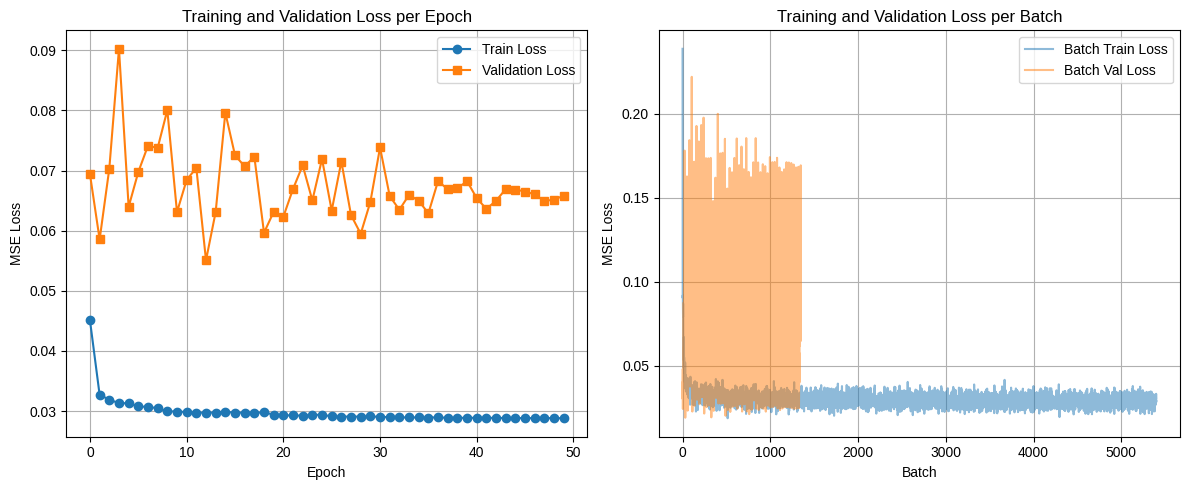

In [43]:
model.to(device)

# 定义损失函数（均方误差）和优化器（Adam）
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 添加学习率衰减
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)

def early_stopping(val_losses, patience=7, min_delta=0.001):
    if len(val_losses) < patience:
        return False
    
    recent_losses = val_losses[-patience:]
    first_loss = recent_losses[0]
    
    # 检查是否持续增加
    return all((loss - first_loss) > min_delta for loss in recent_losses[1:])

num_epochs = 50  # 根据实际情况调整

best_val_loss = float('inf')
patience_counter = 0
patience = 7

# 初始化损失记录列表
train_losses = []
val_losses = []
batch_train_losses = []
batch_val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    
    # 训练阶段
    for batch_X, batch_Y in train_loader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        
        batch_train_losses.append(loss.item())
        epoch_train_loss += loss.item() * batch_X.size(0)
    
    epoch_train_loss /= len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # 验证阶段
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            
            batch_val_losses.append(loss.item())
            epoch_val_loss += loss.item() * batch_X.size(0)
    
    epoch_val_loss /= len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    # 使用统一的格式打印损失值
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.6f} - Val Loss: {epoch_val_loss:.6f}")
    
    # 更新学习率
    scheduler.step(epoch_val_loss)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(batch_train_losses, label='Batch Train Loss', alpha=0.5)
plt.plot(batch_val_losses, label='Batch Val Loss', alpha=0.5)
plt.xlabel('Batch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss per Batch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 预测新数据

定义方法

In [44]:
# 处理新数据（无实际价格）
def process_new_data(df_new):    
    # 添加时间特征
    df_new['weekday_num'] = df_new.index.weekday
    df_new['is_workday'] = (df_new['weekday_num'] < 5).astype(int)
    df_new['is_holiday'] = df_new.index.to_series().apply(lambda x : 1 if cc.is_holiday(x.date()) else 0)
    df_new['season'] = df_new.index.month.map(get_season)
    
    df_new.rename(columns={
        'east_power': 'east_trans_load',
        'non_market_power': 'non_market_output_load',
        'total_load': 'unified_dispatch_load',
        'renewable_power': 'new_energy_output_load',
        'wind_power': 'wind_power_output_load',
        'solar_power': 'solar_power_output_load',
        'bidding_space': 'price_bidding_space'
    }, inplace=True)

    df_new = df_new[['east_trans_load', 'non_market_output_load', 'unified_dispatch_load',
                     'new_energy_output_load', 'wind_power_output_load', 'solar_power_output_load', 'price_bidding_space',
                     'weekday_num', 'is_workday', 'is_holiday', 'season']]
    
    # 标准化数据
    normalized_data = df_new.copy()
    for col in columns_to_scale:
        if col not in ['east_price', 'west_price']:  # 跳过价格列
            scaler = scalers[col]
            normalized_data[col] = scaler.transform(df_new[[col]])
    
    return normalized_data

# 预测窗口
def create_prediction_windows(data, input_length):
    """
    为预测创建输入窗口（无需输出窗口）
    """
    feature_columns = [col for col in data.columns 
                      if col not in ['east_price', 'west_price', 'datetime']]

    data_array = data[feature_columns].values.astype(np.float32)
    
    total_length = len(data_array)
    samples_count = total_length - input_length + 1
    X = np.zeros((samples_count, input_length, len(feature_columns)), dtype=np.float32)
    
    for i in range(samples_count):
        X[i] = data_array[i:i + input_length]
    
    return X

def predict_future_prices(new_data, model, X_new, scalers, output_length=24):
    """预测未来价格并进行后处理"""
    model.eval()
    device = next(model.parameters()).device
    
    print(f"输入数据时间范围: {new_data.index[0]} 到 {new_data.index[-1]}")
    
    with torch.no_grad():
        X_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)
        predictions = model(X_tensor)
        predictions = predictions.cpu().numpy()
    
    # 处理重叠预测
    n_samples = predictions.shape[0]
    output_length = predictions.shape[1]
    n_features = predictions.shape[2]
    
    # 创建累加器数组 - 72小时（3天）
    total_length = 72  # 3天
    predictions_sum = np.zeros((total_length, n_features))
    predictions_count = np.zeros((total_length, n_features))
    
    # 累加预测值
    for i in range(n_samples):
        for j in range(output_length):
            current_idx = i + j
            if current_idx < total_length:
                predictions_sum[current_idx] += predictions[i, j]
                predictions_count[current_idx] += 1
    
    # 安全计算平均值
    averaged_predictions = np.zeros_like(predictions_sum)
    mask = predictions_count > 0
    averaged_predictions[mask] = predictions_sum[mask] / predictions_count[mask]
    
    # 反标准化
    final_predictions = np.zeros_like(averaged_predictions)
    for i, col in enumerate(['east_price', 'west_price']):
        scaler = scalers[col]
        final_predictions[:, i] = scaler.inverse_transform(
            averaged_predictions[:, i].reshape(-1, 1)
        ).ravel()
    
    # 确保预测价格非负
    final_predictions = np.maximum(final_predictions, 0)
    
    # 修正时间索引：从第一天开始
    start_time = new_data.index[0]
    result_index = pd.date_range(
        start=start_time,
        periods=total_length,
        freq='H'
    )
    
    print(f"预测时间范围: {result_index[0]} 到 {result_index[-1]}")
    
    # 创建结果DataFrame
    result_df = pd.DataFrame(
        final_predictions,
        columns=['east_price_pred', 'west_price_pred'],
        index=result_index
    )
    
    return result_df

def plot_three_day_predictions(predictions_df):
    """绘制三天的预测结果"""
    plt.figure(figsize=(15, 10))
    
    # 东区预测
    plt.subplot(2, 1, 1)
    plt.plot(predictions_df.index, predictions_df['east_price_pred'], 
             label='East Price Prediction', marker='o', markersize=4)
    plt.title('East Price Prediction (3 days)')
    plt.xlabel('Hours')
    plt.ylabel('Price (yuan/MWh)')
    plt.grid(True)
    plt.legend()
    
    # 西区预测
    plt.subplot(2, 1, 2)
    plt.plot(predictions_df.index, predictions_df['west_price_pred'], 
             label='West Price Prediction', marker='o', markersize=4)
    plt.title('West Price Prediction (3 days)')
    plt.xlabel('Hours')
    plt.ylabel('Price (yuan/MWh)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def recursive_predict(new_data, model, scalers, input_length=48, forecast_horizon=72):
    """
    采用递归预测方法，每次用最近的 input_length 数据预测接下来 24 小时，
    然后将预测结果拼接到输入中，重复直到覆盖 forecast_horizon 小时.
    
    Args:
        new_data: 未标准化的新数据 DataFrame（其特征顺序需与训练时一致）
        model: 训练好的模型
        scalers: 标准化器字典（用于反标准化价格）
        input_length: 模型输入长度，例如 48
        forecast_horizon: 需要预测的总时长，例如 72
    Returns:
        result_df: 预测结果 DataFrame，索引为时间戳，列为 ['east_price_pred','west_price_pred']
    """
    model.eval()
    device = next(model.parameters()).device
    
    # 预处理新数据（标准化）和取特征，确保特征顺序与训练时保持一致
    processed_data = process_new_data(new_data)
    feature_columns = ['east_trans_load', 'non_market_output_load', 'unified_dispatch_load',
                         'new_energy_output_load', 'wind_power_output_load', 'solar_power_output_load',
                         'price_bidding_space', 'weekday_num', 'is_workday', 'is_holiday', 'season']
    data_array = processed_data[feature_columns].values.astype(np.float32)
    
    # 取最后的 input_length 作为初始输入（注意：这里假设 new_data 足够长）
    current_input = data_array[-input_length:].copy()
    
    predictions_list = []
    current_time = new_data.index[-1]  # 当前数据最后一个时间点
    # 递归预测，直到预测 horizon 小时
    hours_to_predict = forecast_horizon
    while hours_to_predict > 0:
        # 将 current_input shape 转换为 [1, input_length, num_features]
        X_in = current_input.reshape(1, input_length, len(feature_columns))
        X_tensor = torch.tensor(X_in, dtype=torch.float32).to(device)
        with torch.no_grad():
            pred = model(X_tensor)  # 形状 [1, output_length, 2]
        pred = pred.cpu().numpy().squeeze(0)  # shape [output_length, 2]
        
        # 取预测的前min(hours_to_predict, output_length)个小时结果
        step = min(hours_to_predict, pred.shape[0])
        predictions_list.append(pred[:step])
        
        # 更新 current_input: 去掉最早的 step 个时间步，拼接上预测结果的特征版
        # 为了续接下次预测，需要构造下一段预测时所需输入特征，假设其他特征保持不变，
        # 可以直接将预测价（仅目标变量）扩展替代，或使用最新的历史数据更新输入。
        # 这里简单起见，将 current_input 后面 step 个时间步直接用当前最后一行重复替代。
        # 注意：在实际使用中，这部分需要根据具体特征进行合理更新。
        new_rows = current_input[-1:].repeat(step, axis=0)
        current_input = np.concatenate([current_input[step:], new_rows], axis=0)
        
        hours_to_predict -= step
    
    # 拼接所有预测结果
    final_predictions = np.concatenate(predictions_list, axis=0)
    
    # 将预测结果反标准化（目标变量）
    final_predictions_orig = np.zeros_like(final_predictions)
    for i, col in enumerate(['east_price', 'west_price']):
        scaler = scalers[col]
        final_predictions_orig[:, i] = scaler.inverse_transform(final_predictions[:, i].reshape(-1, 1)).ravel()
    
    final_predictions_orig = np.maximum(final_predictions_orig, 0)
    
    # 创建时间索引，从 new_data.index[-1] 后开始逐小时
    result_index = pd.date_range(start=new_data.index[0] + pd.Timedelta(hours=1),
                                 periods=forecast_horizon, freq='H')
    result_df = pd.DataFrame(final_predictions_orig, columns=['east_price_pred', 'west_price_pred'], index=result_index)
    return result_df

调用

输入数据时间范围: 2025-03-20 01:00:00 到 2025-03-23 00:00:00
预测时间范围: 2025-03-20 01:00:00 到 2025-03-23 00:00:00


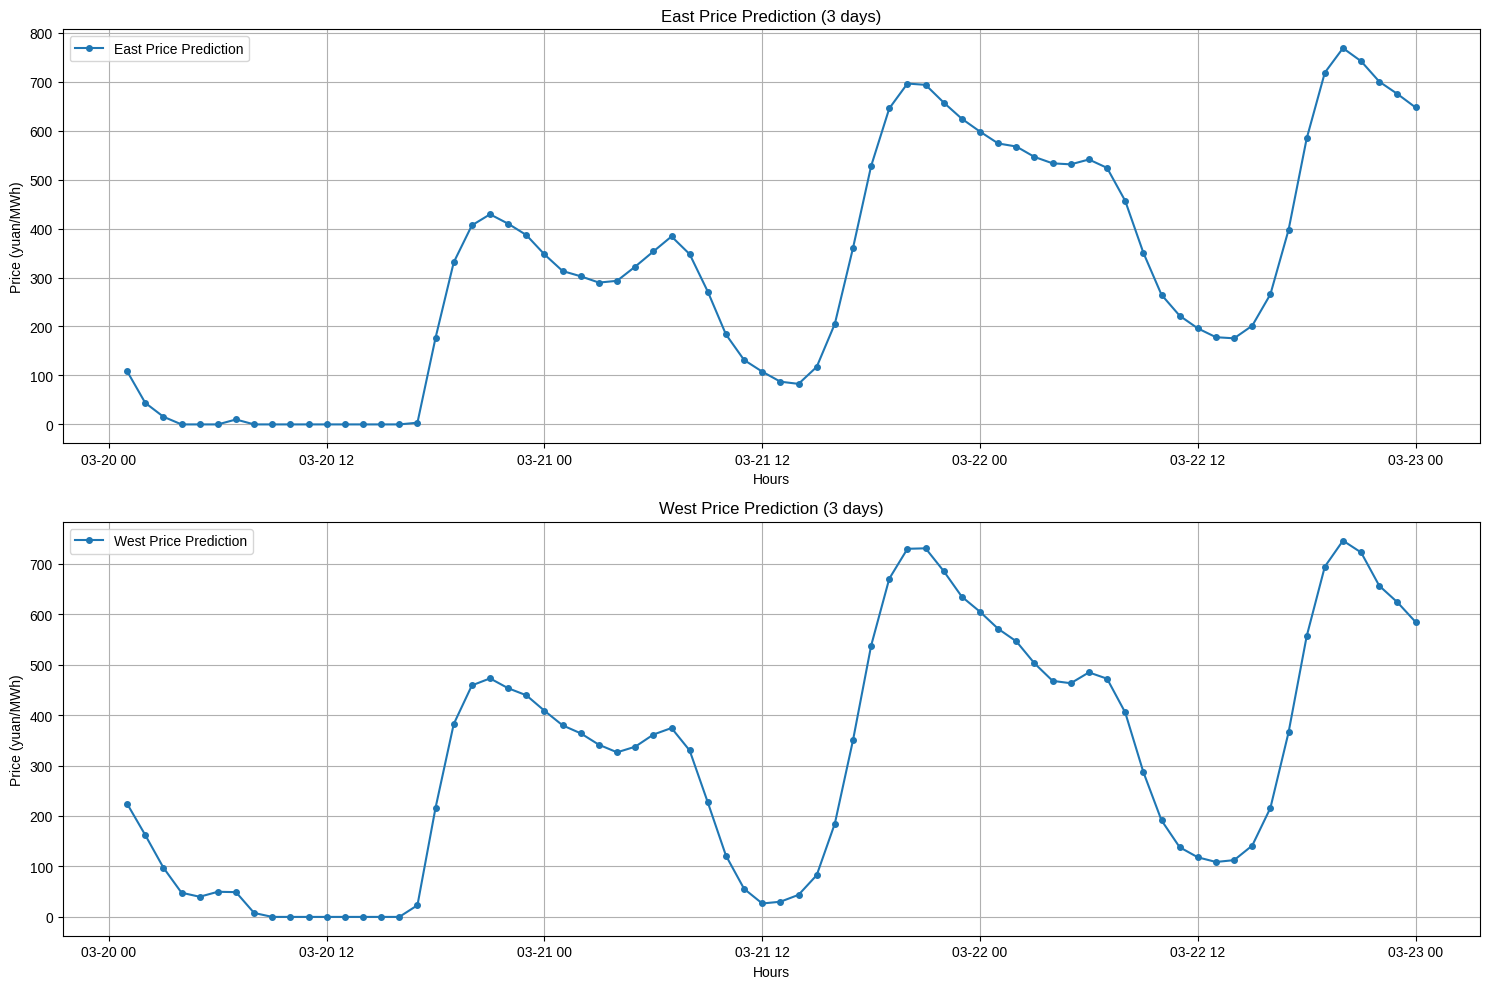

In [45]:
# 读取新数据
new_data = pd.read_csv("../data/预测数据20250319_24点.csv", sep=",")
new_data['datetime'] = pd.to_datetime(new_data['datetime'])
new_data.set_index('datetime', inplace=True)

# 处理数据
processed_data = process_new_data(new_data)

# 创建预测窗口
X_new = create_prediction_windows(processed_data, input_length)

# 预测价格
predictions = predict_future_prices(new_data, model, X_new, scalers)

# 保存结果
predictions.to_csv("../output/three_day_predictions.csv")

# 可视化预测结果
plot_three_day_predictions(predictions)

# result_df = recursive_predict(new_data, model, scalers, input_length=48, forecast_horizon=72)
# print("预测时间范围:", result_df.index[0], "到", result_df.index[-1])
# result_df.to_csv("../output/recursive_three_day_predictions.csv")
# plot_three_day_predictions(result_df)

# 测试集

读取2025年新数据

In [46]:
elec_price_df_2025 = pd.read_csv(data_path_2025 + "202501电价数据_24点_cleaned.csv", sep="\t")
elec_out_price_df_2025 = pd.read_csv(data_path_2025 + "202501东送计划_96点_cleaned.csv", sep="\t")
non_martket_elec_gen_df_2025 = pd.read_csv(data_path_2025 + "202501非市场化出力_96点_cleaned.csv", sep="\t")
ele_load_df_2025 = pd.read_csv(data_path_2025 + "202501负荷数据_96点_cleaned.csv", sep="\t")
new_energy_elec_gen_df_2025 = pd.read_csv(data_path_2025 + "202501新能源处理_96点_cleaned.csv", sep="\t")

df_15_2025 = [elec_out_price_df_2025, non_martket_elec_gen_df_2025, ele_load_df_2025, new_energy_elec_gen_df_2025]

for i in range(len(df_15_2025)):
    df = df_15_2025[i]
    df = df.sort_values('datetime')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df = df.resample('H', closed='right', label='right').mean()
    df_15_2025[i] = df

elec_price_df_2025['datetime'] = pd.to_datetime(elec_price_df_2025['datetime'])
elec_price_df_2025.set_index('datetime', inplace=True)

merged_df_2025 = pd.concat([elec_price_df_2025] + df_15_2025, axis=1)
print(merged_df_2025.head())

                     全网统一出清电价  呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格  东送计划预测  \
datetime                                                                 
2025-01-01 01:00:00   661.271    779.739    573.111      385.0  2100.0   
2025-01-01 02:00:00   643.997    796.526    531.438      380.0  2100.0   
2025-01-01 03:00:00   515.217    546.624    493.548      380.0  2100.0   
2025-01-01 04:00:00   487.129    500.144    478.282      380.0  2100.0   
2025-01-01 05:00:00   445.517    412.695    468.820      380.0  2100.0   

                        东送计划实测    非市场出力计划  非市场出力计划实测     统调负荷预测     统调负荷实测  \
datetime                                                                     
2025-01-01 01:00:00  1670.2425  6658.9950  5482.6525  42917.100  42987.150   
2025-01-01 02:00:00  1580.2400  6720.4800  5412.9775  42751.700  42983.475   
2025-01-01 03:00:00   499.3300  6704.1050  5258.6200  42642.675  42857.725   
2025-01-01 04:00:00   455.1300  6695.0175  5252.9875  42616.875  42598.575   
2025-01-01 05

数据预处理

In [47]:
# 天气
weather_data_2025_all = pd.read_csv(data_path_2025 + '内蒙2025天气.csv', sep=',')

''' 天气参数
id: 数据id
region_code: 行政区号
region_name: 行政区名
t2m: 2米温度
ws10m: 10米风速
ssrd: 向下表面太阳辐射（辐照）
tp: 总降水量(precipitation)
rh: 相对湿度
datetime: 时间戳
lng: 经度
lat: 纬度
'''
# 设置列名
weather_data_2025_all.columns = ['id', 'region_code', 'region_name', 't2m', 'ws10m', 'ssrd', 'tp', 'rh', 'datetime', 'lng', 'lat']
weather_data_2025 = weather_data_2025_all.drop(columns=['id', 'lng', 'lat', 'region_name'])
weather_data_2025['datetime'] = pd.to_datetime(weather_data_2025['datetime'], dayfirst=True)
weather_data_2025.set_index('datetime', inplace=True)
weather_data_2025_filtered = weather_data_2025[weather_data_2025['region_code'].isin([1501, 1502])]

weather_1501 = weather_data_2025_filtered[weather_data_2025_filtered['region_code'] == 1501].copy()
weather_1502 = weather_data_2025_filtered[weather_data_2025_filtered['region_code'] == 1502].copy()
weather_1501.drop(columns=['region_code'], inplace=True)
weather_1502.drop(columns=['region_code'], inplace=True)
weather_1501.rename(columns={
    't2m': 't2m_1501',
    'ws10m': 'ws10m_1501',
    'ssrd': 'ssrd_1501',
    'tp': 'tp_1501',
    'rh': 'rh_1501'
}, inplace=True)
weather_1502.rename(columns={
    't2m': 't2m_1502',
    'ws10m': 'ws10m_1502',
    'ssrd': 'ssrd_1502',
    'tp': 'tp_1502',
    'rh': 'rh_1502'
}, inplace=True)

weather_1501 = weather_1501[~weather_1501.index.duplicated(keep='first')]
weather_1502 = weather_1502[~weather_1502.index.duplicated(keep='first')]

merged_weather_2025 = pd.merge(weather_1501, weather_1502, left_index=True, right_index=True, how='outer')

# 合并数据+丢弃预测数据
merged_df_with_weather = merged_df_2025.merge(merged_weather_2025, left_index=True, right_index=True, how='outer')
merged_df_with_weather['price_bidding_space'] = merged_df_with_weather['统调负荷预测'] + merged_df_with_weather['东送计划预测'] - merged_df_with_weather['新能源出力预测'] - merged_df_with_weather['非市场出力计划']
merged_df_filtered_2025 = merged_df_with_weather.drop(columns=['东送计划实测', '非市场出力计划实测', '统调负荷实测', '新能源出力实测', '风电出力实测', '光伏出力实测'])

# # 滞后特征
# merged_df_filtered_2025['east_price_lag_1'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(1)
# merged_df_filtered_2025['east_price_lag_2'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(2)
# merged_df_filtered_2025['east_price_lag_3'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(3)

# merged_df_filtered_2025['west_price_lag_1'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(1)
# merged_df_filtered_2025['west_price_lag_2'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(2)
# merged_df_filtered_2025['west_price_lag_3'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(3)

# for day in range(1, 8):
#     merged_df_filtered_2025[f'east_price_lag_day_{day}'] = merged_df_filtered_2025['呼包东统一出清电价'].shift(24 * day)
#     merged_df_filtered_2025[f'west_price_lag_day_{day}'] = merged_df_filtered_2025['呼包西统一出清电价'].shift(24 * day)

merged_df_filtered_2025 = merged_df_filtered_2025.dropna()

# 添加节假日、季节、工作日与周末、星期几特征
merged_df_filtered_2025['weekday_num'] = merged_df_filtered_2025.index.weekday
merged_df_filtered_2025['is_workday'] = (merged_df_filtered_2025['weekday_num'] < 5).astype(int)
merged_df_filtered_2025['is_holiday'] = merged_df_filtered_2025.index.to_series().apply(lambda x : 1 if cc.is_holiday(x.date()) else 0)

merged_df_filtered_2025['season'] = merged_df_filtered_2025.index.month.map(get_season)

print(merged_df_filtered_2025.columns)

# 检查并处理缺失数据
df_cleaned_2025 = deal_missing_data(merged_df_filtered_2025)


Index(['全网统一出清电价', '呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划',
       '统调负荷预测', '新能源出力预测', '风电出力预测', '光伏出力预测', 't2m_1501', 'ws10m_1501',
       'ssrd_1501', 'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502',
       'ssrd_1502', 'tp_1502', 'rh_1502', 'price_bidding_space', 'weekday_num',
       'is_workday', 'is_holiday', 'season'],
      dtype='object')
Initial missing timestamps: 0
No need to deal missing data.


In [48]:
# 只保留竞价空间
tmp_df = df_cleaned_2025.copy()

tmp_df.drop(
    columns=
    ['全网统一出清电价', 't2m_1501', 'ws10m_1501', 'ssrd_1501',
       'tp_1501', 'rh_1501', 't2m_1502', 'ws10m_1502', 'ssrd_1502', 'tp_1502',
       'rh_1502'],
     inplace=True
     )

df_cleaned_2025 = tmp_df.copy()

print(df_cleaned_2025.columns)
print(df_cleaned_2025.head(1))
print(df_cleaned_2025.tail(1))

Index(['呼包东统一出清电价', '呼包西统一出清电价', '日前预出清电能价格', '东送计划预测', '非市场出力计划', '统调负荷预测',
       '新能源出力预测', '风电出力预测', '光伏出力预测', 'price_bidding_space', 'weekday_num',
       'is_workday', 'is_holiday', 'season'],
      dtype='object')
                     呼包东统一出清电价  呼包西统一出清电价  日前预出清电能价格  东送计划预测   非市场出力计划  \
datetime                                                                 
2025-01-01 01:00:00    779.739    573.111      385.0  2100.0  6658.995   

                      统调负荷预测    新能源出力预测   风电出力预测   光伏出力预测  \
datetime                                                    
2025-01-01 01:00:00  42917.1  7972.3575  7944.21  28.1475   

                     price_bidding_space  weekday_num  is_workday  is_holiday  \
datetime                                                                        
2025-01-01 01:00:00           30385.7475            2           1           1   

                     season  
datetime                     
2025-01-01 01:00:00       3  
            呼包东统一出清电价  呼包西统一出清电价  日前预出

In [49]:
# 重命名列名
df_cleaned_2025.rename(columns={
    '全网统一出清电价': 'unified_price', 
    '呼包东统一出清电价': 'east_price',
    '呼包西统一出清电价': 'west_price',
    '东送计划实测': 'east_trans_load', 
    '非市场出力计划实测': 'non_market_output_load',
    '统调负荷实测': 'unified_dispatch_load',
    '新能源出力实测': 'new_energy_output_load',
    '风电出力实测': 'wind_power_output_load',
    '光伏出力实测': 'solar_power_output_load'
}, inplace=True)

print(df_cleaned_2025.columns)

# 使用已有的标准化器进行数据标准化
normalized_data_2025 = df_cleaned_2025.copy()
for col in columns_to_scale:
    scaler = scalers[col]
    normalized_data_2025[col] = scaler.transform(df_cleaned_2025[[col]])

# 使用已有的 create_sliding_windows 函数创建测试数据
X_test, Y_test = create_sliding_windows(normalized_data_2025, input_length, output_length, 
                            feature_indices, target_indices)

Index(['east_price', 'west_price', '日前预出清电能价格', '东送计划预测', '非市场出力计划', '统调负荷预测',
       '新能源出力预测', '风电出力预测', '光伏出力预测', 'price_bidding_space', 'weekday_num',
       'is_workday', 'is_holiday', 'season'],
      dtype='object')


KeyError: "None of [Index(['east_trans_load'], dtype='object')] are in the [columns]"

预测

In [ ]:
model.to(device)
model.eval()  # set model to evaluation mode
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_pred = model(X_test_tensor)  # predictions in normalized scale
    Y_pred = Y_pred.cpu().numpy()  # convert predictions to numpy array for post-processing

In [ ]:
def process_overlapping_predictions(Y_pred, Y_test, output_length, scalers, target_columns):
    """处理滑动窗口的重叠预测值，并进行反标准化
    
    Args:
        Y_pred: 模型预测值，形状(samples, output_length, n_features)
        Y_test: 实际值，形状(samples, output_length, n_features)
        output_length: 预测序列长度（通常是24）
        scalers: 标准化器字典
        target_columns: 目标特征列名列表 ['east_price', 'west_price']
    """
    n_samples = Y_pred.shape[0]
    n_features = Y_pred.shape[2]
    
    # 创建累加器和计数器
    predictions_sum = np.zeros((n_samples + output_length - 1, n_features))
    predictions_count = np.zeros((n_samples + output_length - 1, n_features))
    true_values = np.zeros((n_samples + output_length - 1, n_features))
    
    # 累加每个滑动窗口的预测值
    for i in range(n_samples):
        for j in range(output_length):
            predictions_sum[i + j] += Y_pred[i, j]
            predictions_count[i + j] += 1
            true_values[i + j] = Y_test[i, j]
    
    # 计算平均值
    averaged_predictions = predictions_sum / predictions_count
    
    # 反标准化
    averaged_predictions_orig = np.zeros_like(averaged_predictions)
    true_values_orig = np.zeros_like(true_values)
    
    for i, col in enumerate(target_columns):
        scaler = scalers[col]
        averaged_predictions_orig[:, i] = scaler.inverse_transform(
            averaged_predictions[:, i].reshape(-1, 1)).ravel()
        true_values_orig[:, i] = scaler.inverse_transform(
            true_values[:, i].reshape(-1, 1)).ravel()
    
    averaged_predictions_orig = np.maximum(averaged_predictions_orig, 0)
    
    return averaged_predictions_orig, true_values_orig

# 处理重叠预测并反标准化
averaged_predictions_orig, true_values_orig = process_overlapping_predictions(
    Y_pred=Y_pred, 
    Y_test=Y_test, 
    output_length=output_length,
    scalers=scalers,
    target_columns=['east_price', 'west_price']
)

# 绘制平均后的预测结果
def plot_averaged_predictions(true_values, averaged_predictions, start_idx=0, window_size=24):
    """绘制平均后的预测结果
    
    Args:
        true_values: 反标准化后的真实值
        averaged_predictions: 反标准化后的预测值
        start_idx: 起始索引
        window_size: 显示窗口大小（默认48小时）
    """
    plt.style.use('seaborn-v0_8')
    plt.figure(figsize=(15, 10))
    
    time_steps = np.arange(window_size)
    
    # 东区电价对比图
    plt.subplot(2, 1, 1)
    plt.plot(time_steps, true_values[start_idx:start_idx+window_size, 0], 
             label='Actual Values', marker='o', markersize=4, color='blue')
    plt.plot(time_steps, averaged_predictions[start_idx:start_idx+window_size, 0], 
             label='Predictions', marker='x', markersize=4, color='red')
    plt.title(f'East Price', fontsize=14)
    plt.xlabel('hours', fontsize=12)
    plt.ylabel('price (yuan/MWh)', fontsize=12)  # 添加单位
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 西区电价对比图
    plt.subplot(2, 1, 2)
    plt.plot(time_steps, true_values[start_idx:start_idx+window_size, 1], 
             label='Actual Values', marker='o', markersize=4, color='blue')
    plt.plot(time_steps, averaged_predictions[start_idx:start_idx+window_size, 1], 
             label='Predictions', marker='x', markersize=4, color='red')
    plt.title(f'West Price', fontsize=14)
    plt.xlabel('hours', fontsize=12)
    plt.ylabel('price (yuan/MWh)', fontsize=12)  # 添加单位
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 绘制平均后的预测结果
plot_averaged_predictions(true_values_orig, averaged_predictions_orig, start_idx=24*0)

# 计算平均后的评估指标
mse_avg = np.mean((true_values_orig - averaged_predictions_orig) ** 2, axis=0)
mae_avg = np.mean(np.abs(true_values_orig - averaged_predictions_orig), axis=0)
print(f"\n评估指标 (原始单位：元/MWh):")
print(f"东区 - MSE: {mse_avg[0]:.2f}, MAE: {mae_avg[0]:.2f}")
print(f"西区 - MSE: {mse_avg[1]:.2f}, MAE: {mae_avg[1]:.2f}")

# 计算相对误差
mape_avg = np.mean(np.abs((true_values_orig - averaged_predictions_orig) / true_values_orig), axis=0) * 100
print(f"\n相对误差:")
print(f"东区 - MAPE: {mape_avg[0]:.2f}%")
print(f"西区 - MAPE: {mape_avg[1]:.2f}%")